In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.linear_model import *
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_curve, confusion_matrix, log_loss, auc
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.impute import KNNImputer
from collections import Counter
from itertools import pairwise
from sklearn.model_selection import cross_validate
import tensorflow as tf
import matplotlib.cm as cm

In [2]:
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(context='notebook', palette='viridis')

In [3]:
df = pd.read_csv(
    "LSTM-Multivariate_pollution.csv")  # .drop(columns=["date"])
print(df.shape)
df.head()

(43800, 9)


,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [4]:
df['date'] = pd.to_datetime(df['date'])

In [5]:
display(df.info(), df.describe(), df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       43800 non-null  datetime64[ns]
 1   pollution  43800 non-null  float64       
 2   dew        43800 non-null  int64         
 3   temp       43800 non-null  float64       
 4   press      43800 non-null  float64       
 5   wnd_dir    43800 non-null  object        
 6   wnd_spd    43800 non-null  float64       
 7   snow       43800 non-null  int64         
 8   rain       43800 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(1)
memory usage: 3.0+ MB


None

,date,pollution,dew,temp,press,wnd_spd,snow,rain
count,43800,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,2012-07-02 11:30:00,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
min,2010-01-02 00:00:00,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,2011-04-03 05:45:00,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,2012-07-02 11:30:00,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,2013-10-01 17:15:00,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,2014-12-31 23:00:00,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000
std,NaN,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247


,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


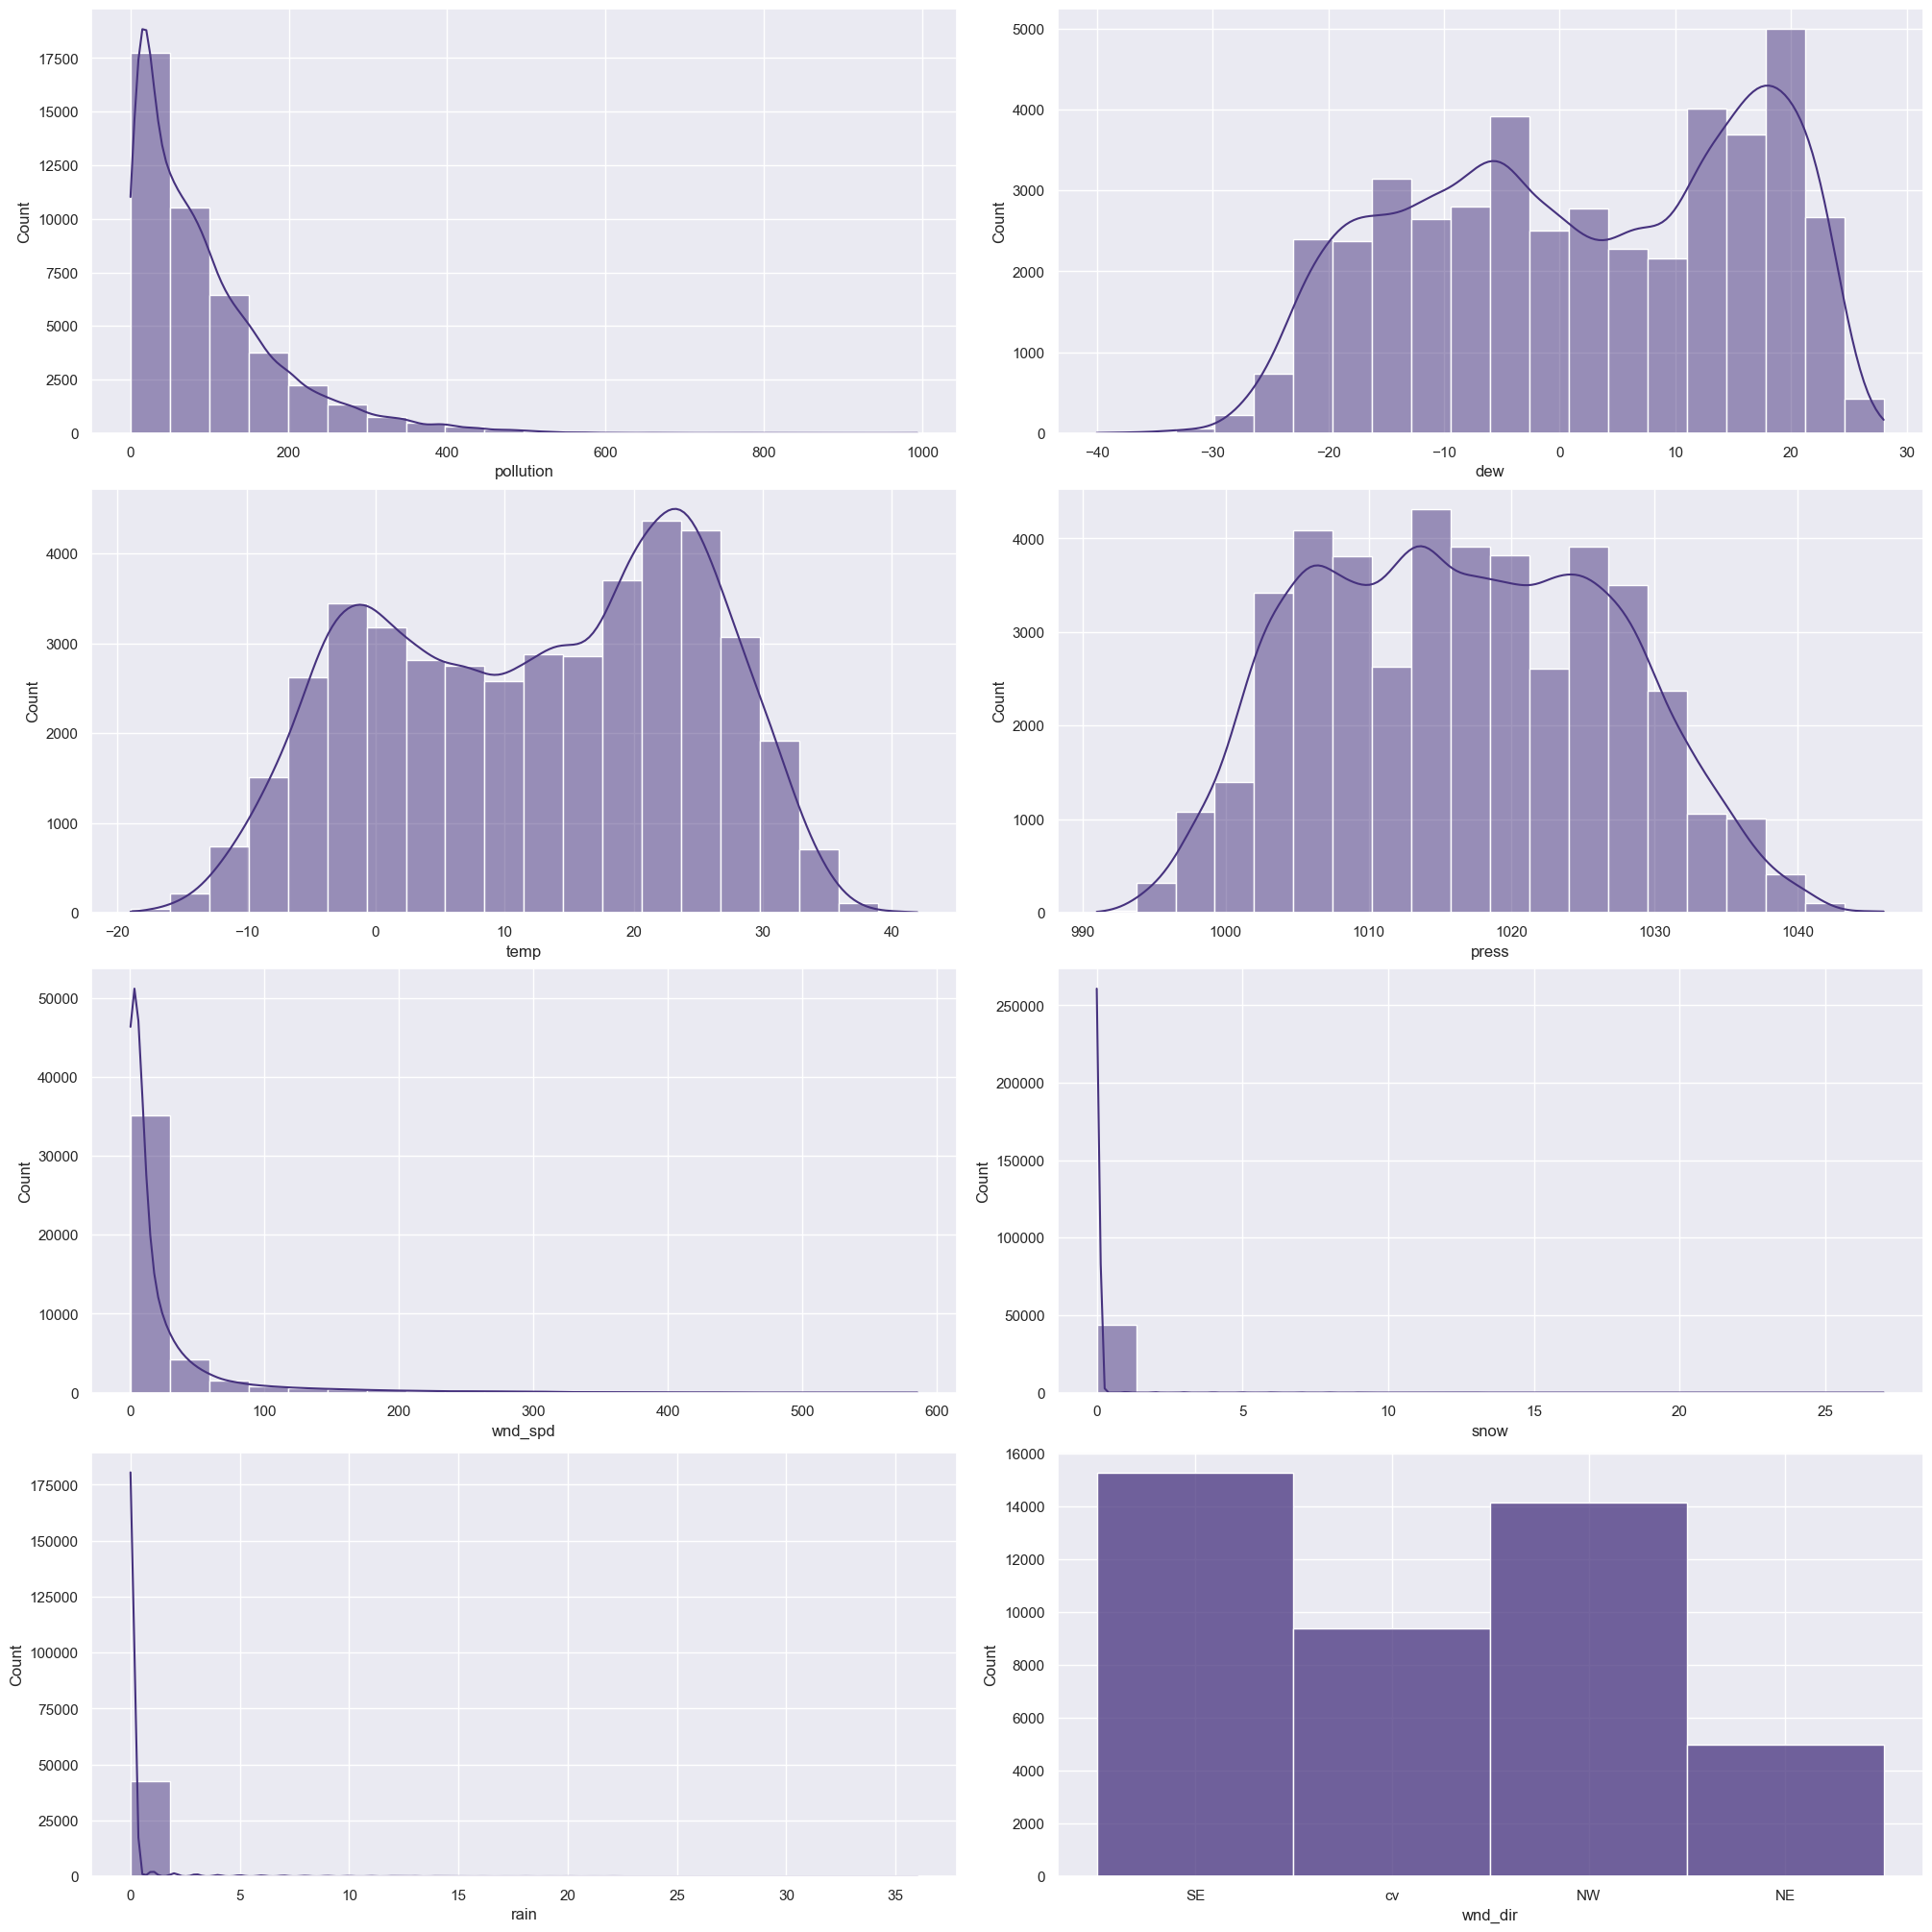

In [6]:
numerical = ['pollution',	'dew',	'temp',	'press', 'wnd_spd', 'snow', 'rain']
fig, axs = plt.subplots(4, 2,
                        figsize=(20, 20), constrained_layout=True)

for i, f in enumerate(numerical):
    sns.histplot(x=f, data=df,  kde=True,
                 ax=axs[i//2][i % 2], bins=20,
                 palette=sns.color_palette("viridis", 2))
sns.histplot(x='wnd_dir', data=df)

plt.show()

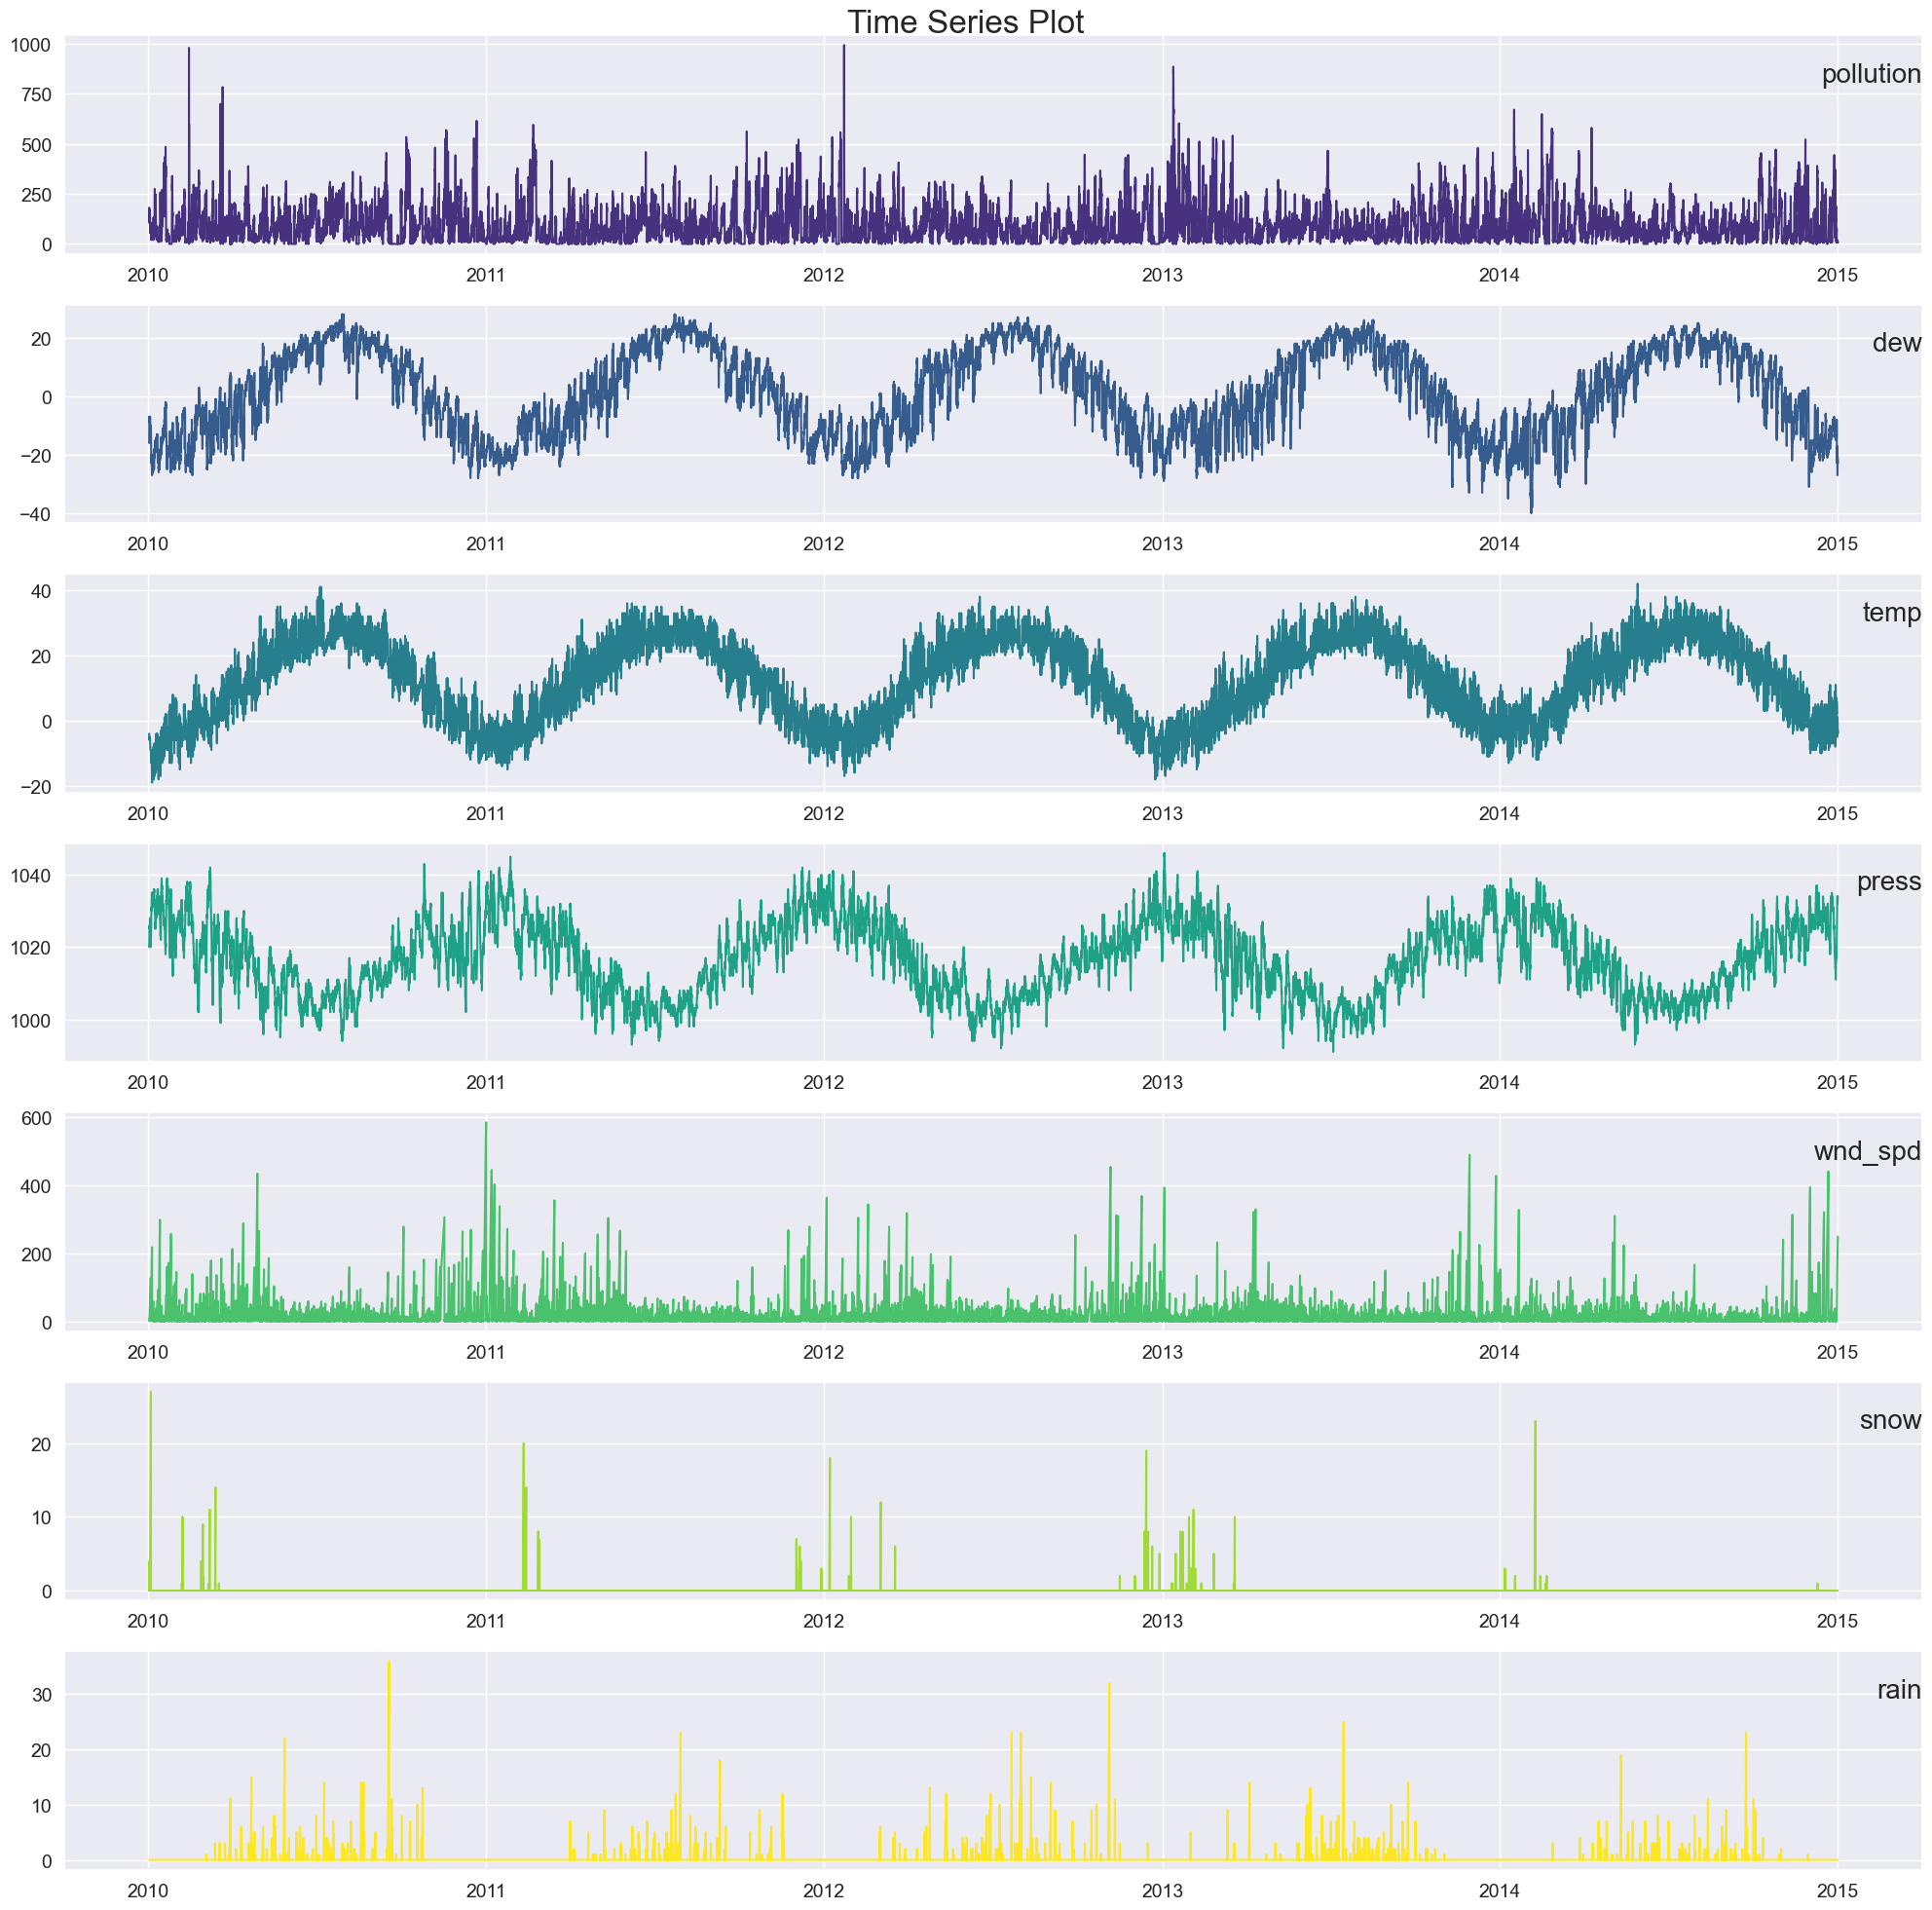

In [7]:
time_vals = ['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain']
fig, axs = plt.subplots(len(time_vals), 1, figsize=(20, 20), facecolor='white')
i = 1
for col, ax in zip(time_vals, axs):
    ax.plot(df['date'], df[col].values, color=cm.viridis(i/len(time_vals)))
    ax.set_title(col, y=0.75, loc='right', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True)
    i += 1

plt.suptitle('Time Series Plot', fontsize=24)
plt.tight_layout()
plt.show()

In [8]:
print(f"Pollution>600: {df[df['pollution'] > 600].shape[0]}")

Pollution>600: 32


In [9]:
print(
    f"Snow>10: {df[df['snow'] > 10].shape}",
    f"Rain>20: {df[df['rain'] > 20].shape}",
    sep='\n')

Snow>10: (66, 9)
Rain>20: (46, 9)


In [10]:
print(
    f"Wind Speed>350: {df[df['wnd_spd'] > 350].shape}",
)

Wind Speed>350: (160, 9)


In [11]:
df['snow'] = df['snow'].apply(lambda x: 10 if x > 10 else x)
df['rain'] = df['rain'].apply(lambda x: 20 if x > 20 else x)

df['pollution'] = df['pollution'].apply(lambda x: 600 if x > 600 else x)
df['wnd_spd'] = df['wnd_spd'].apply(lambda x: 350 if x > 350 else x)
# df['wnd_spd'] = np.log(df['wnd_spd'])

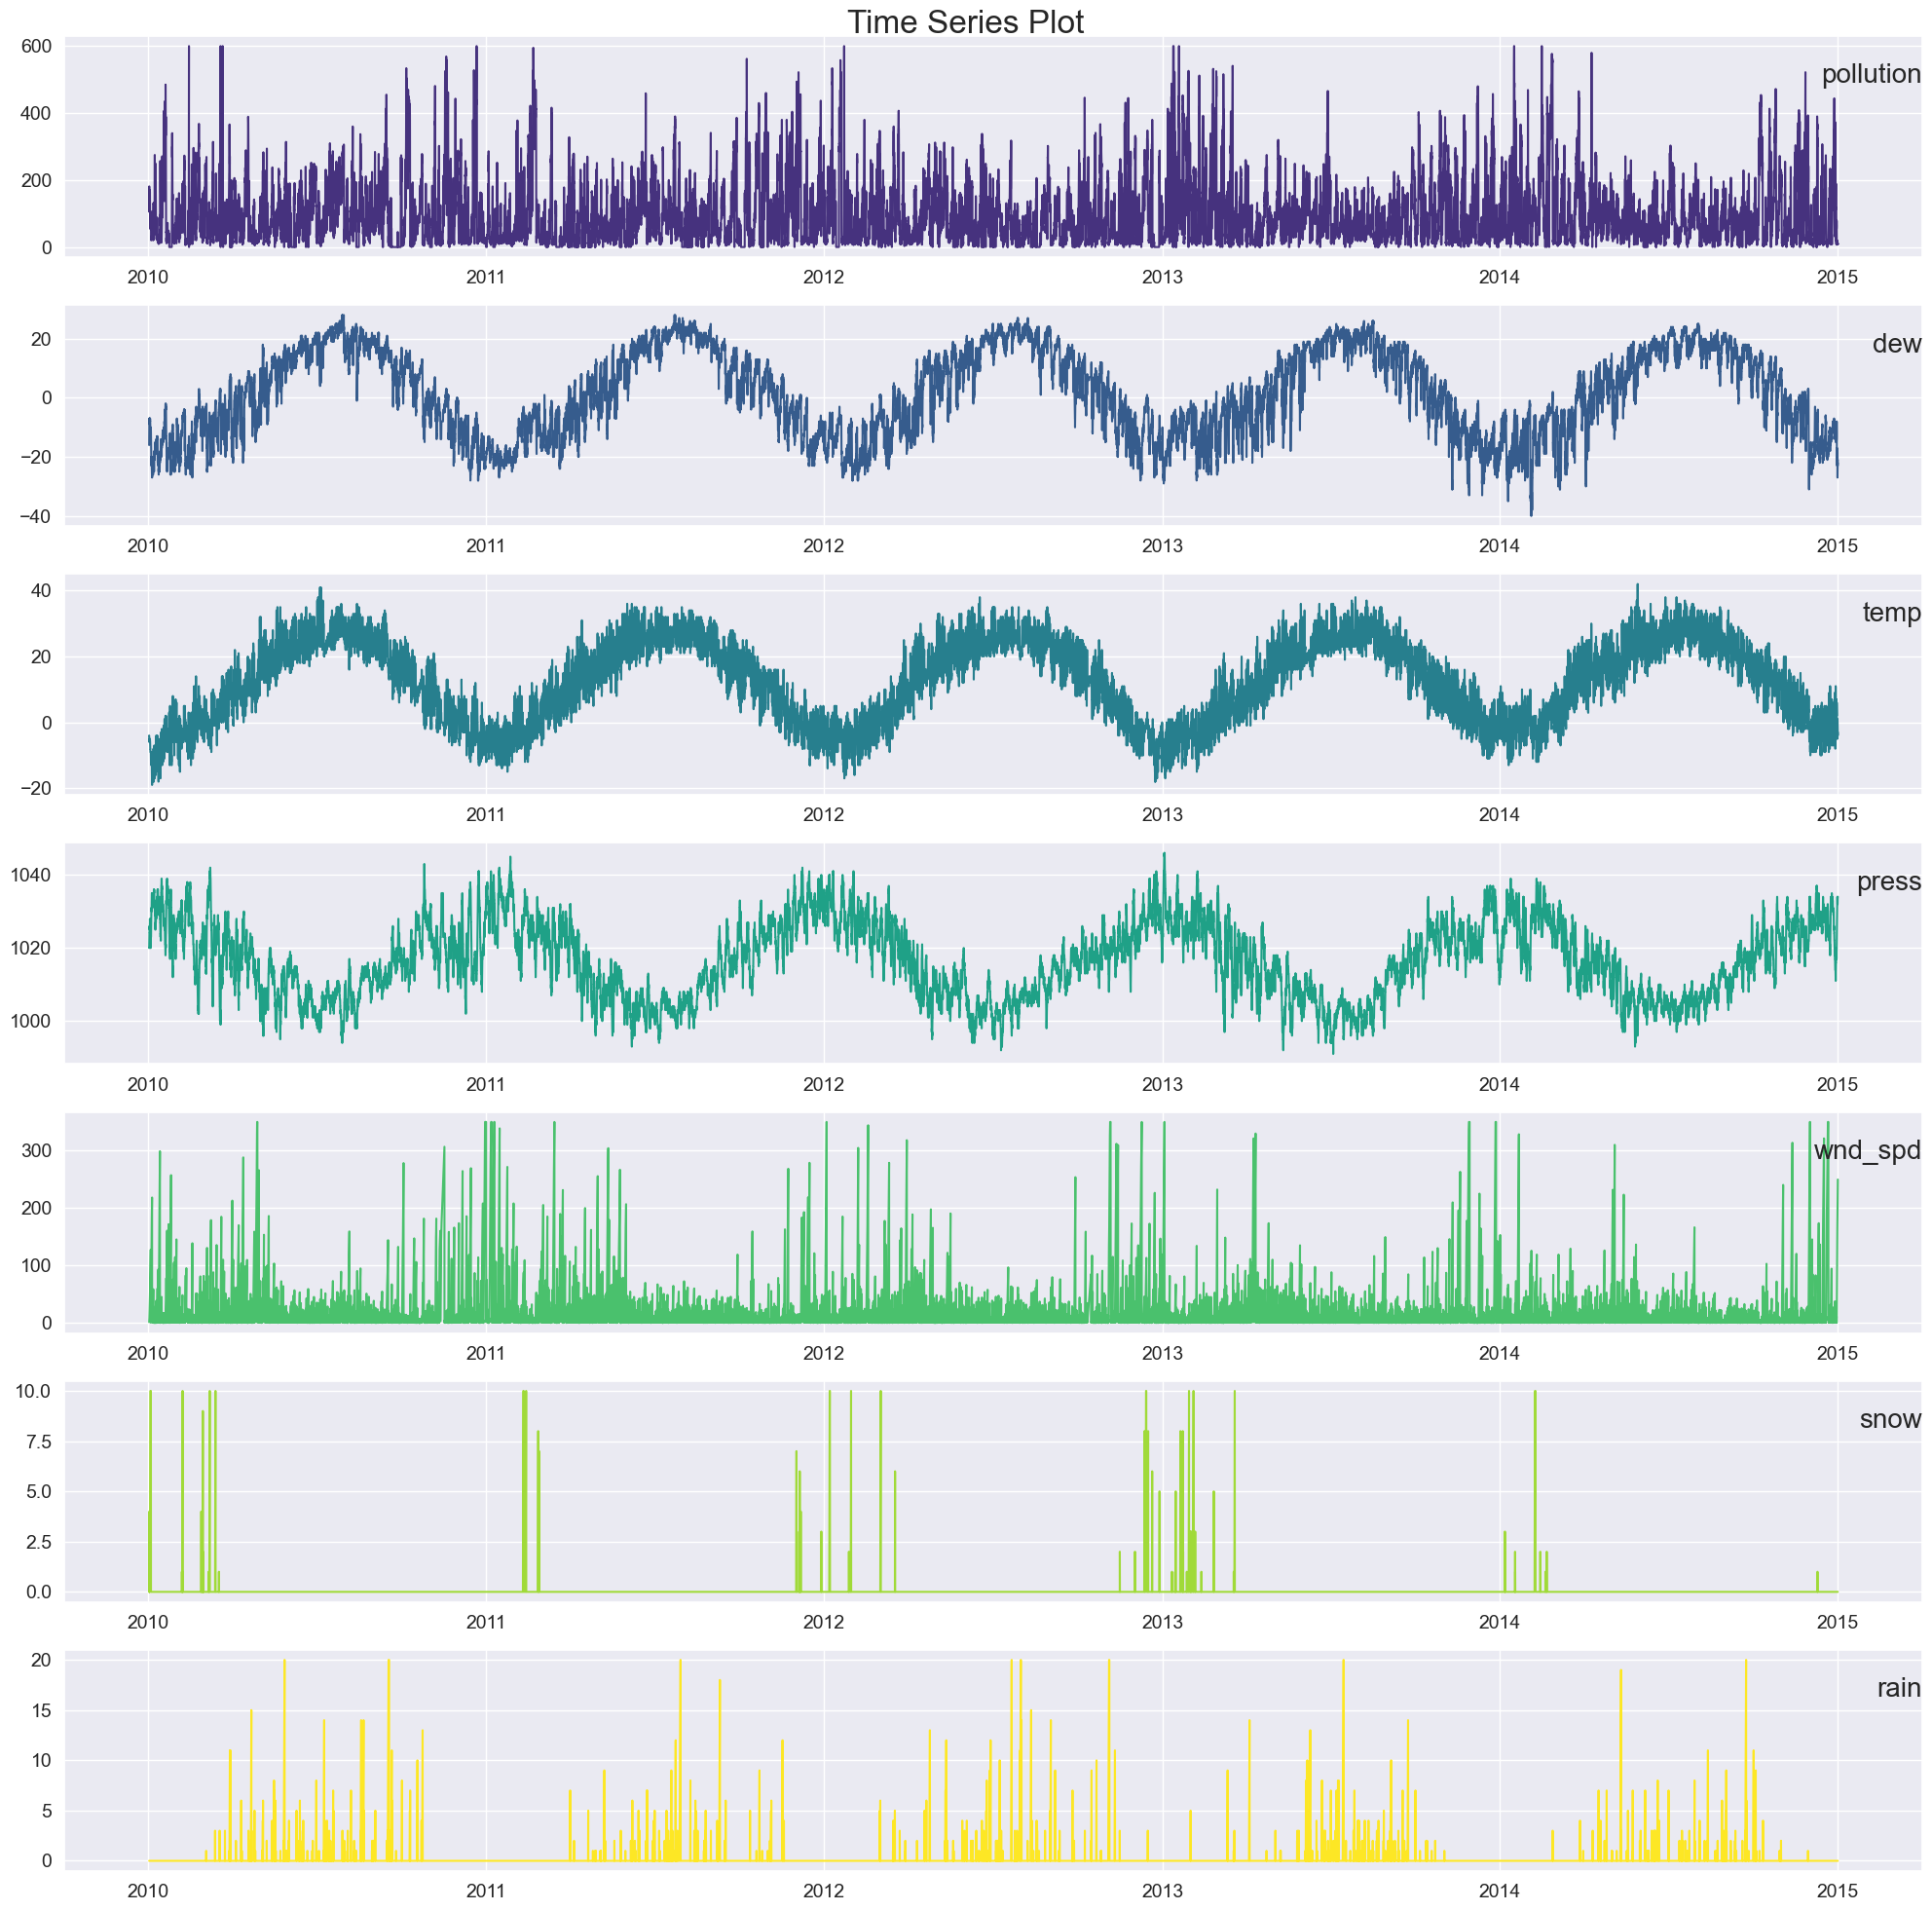

In [12]:
time_vals = ['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain']
fig, axs = plt.subplots(len(time_vals), 1, figsize=(20, 20), facecolor='white')
i = 1
for col, ax in zip(time_vals, axs):
    ax.plot(df['date'], df[col].values, color=cm.viridis(i/len(time_vals)))
    ax.set_title(col, y=0.75, loc='right', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True)
    i += 1

plt.suptitle('Time Series Plot', fontsize=24)
plt.tight_layout()
plt.show()

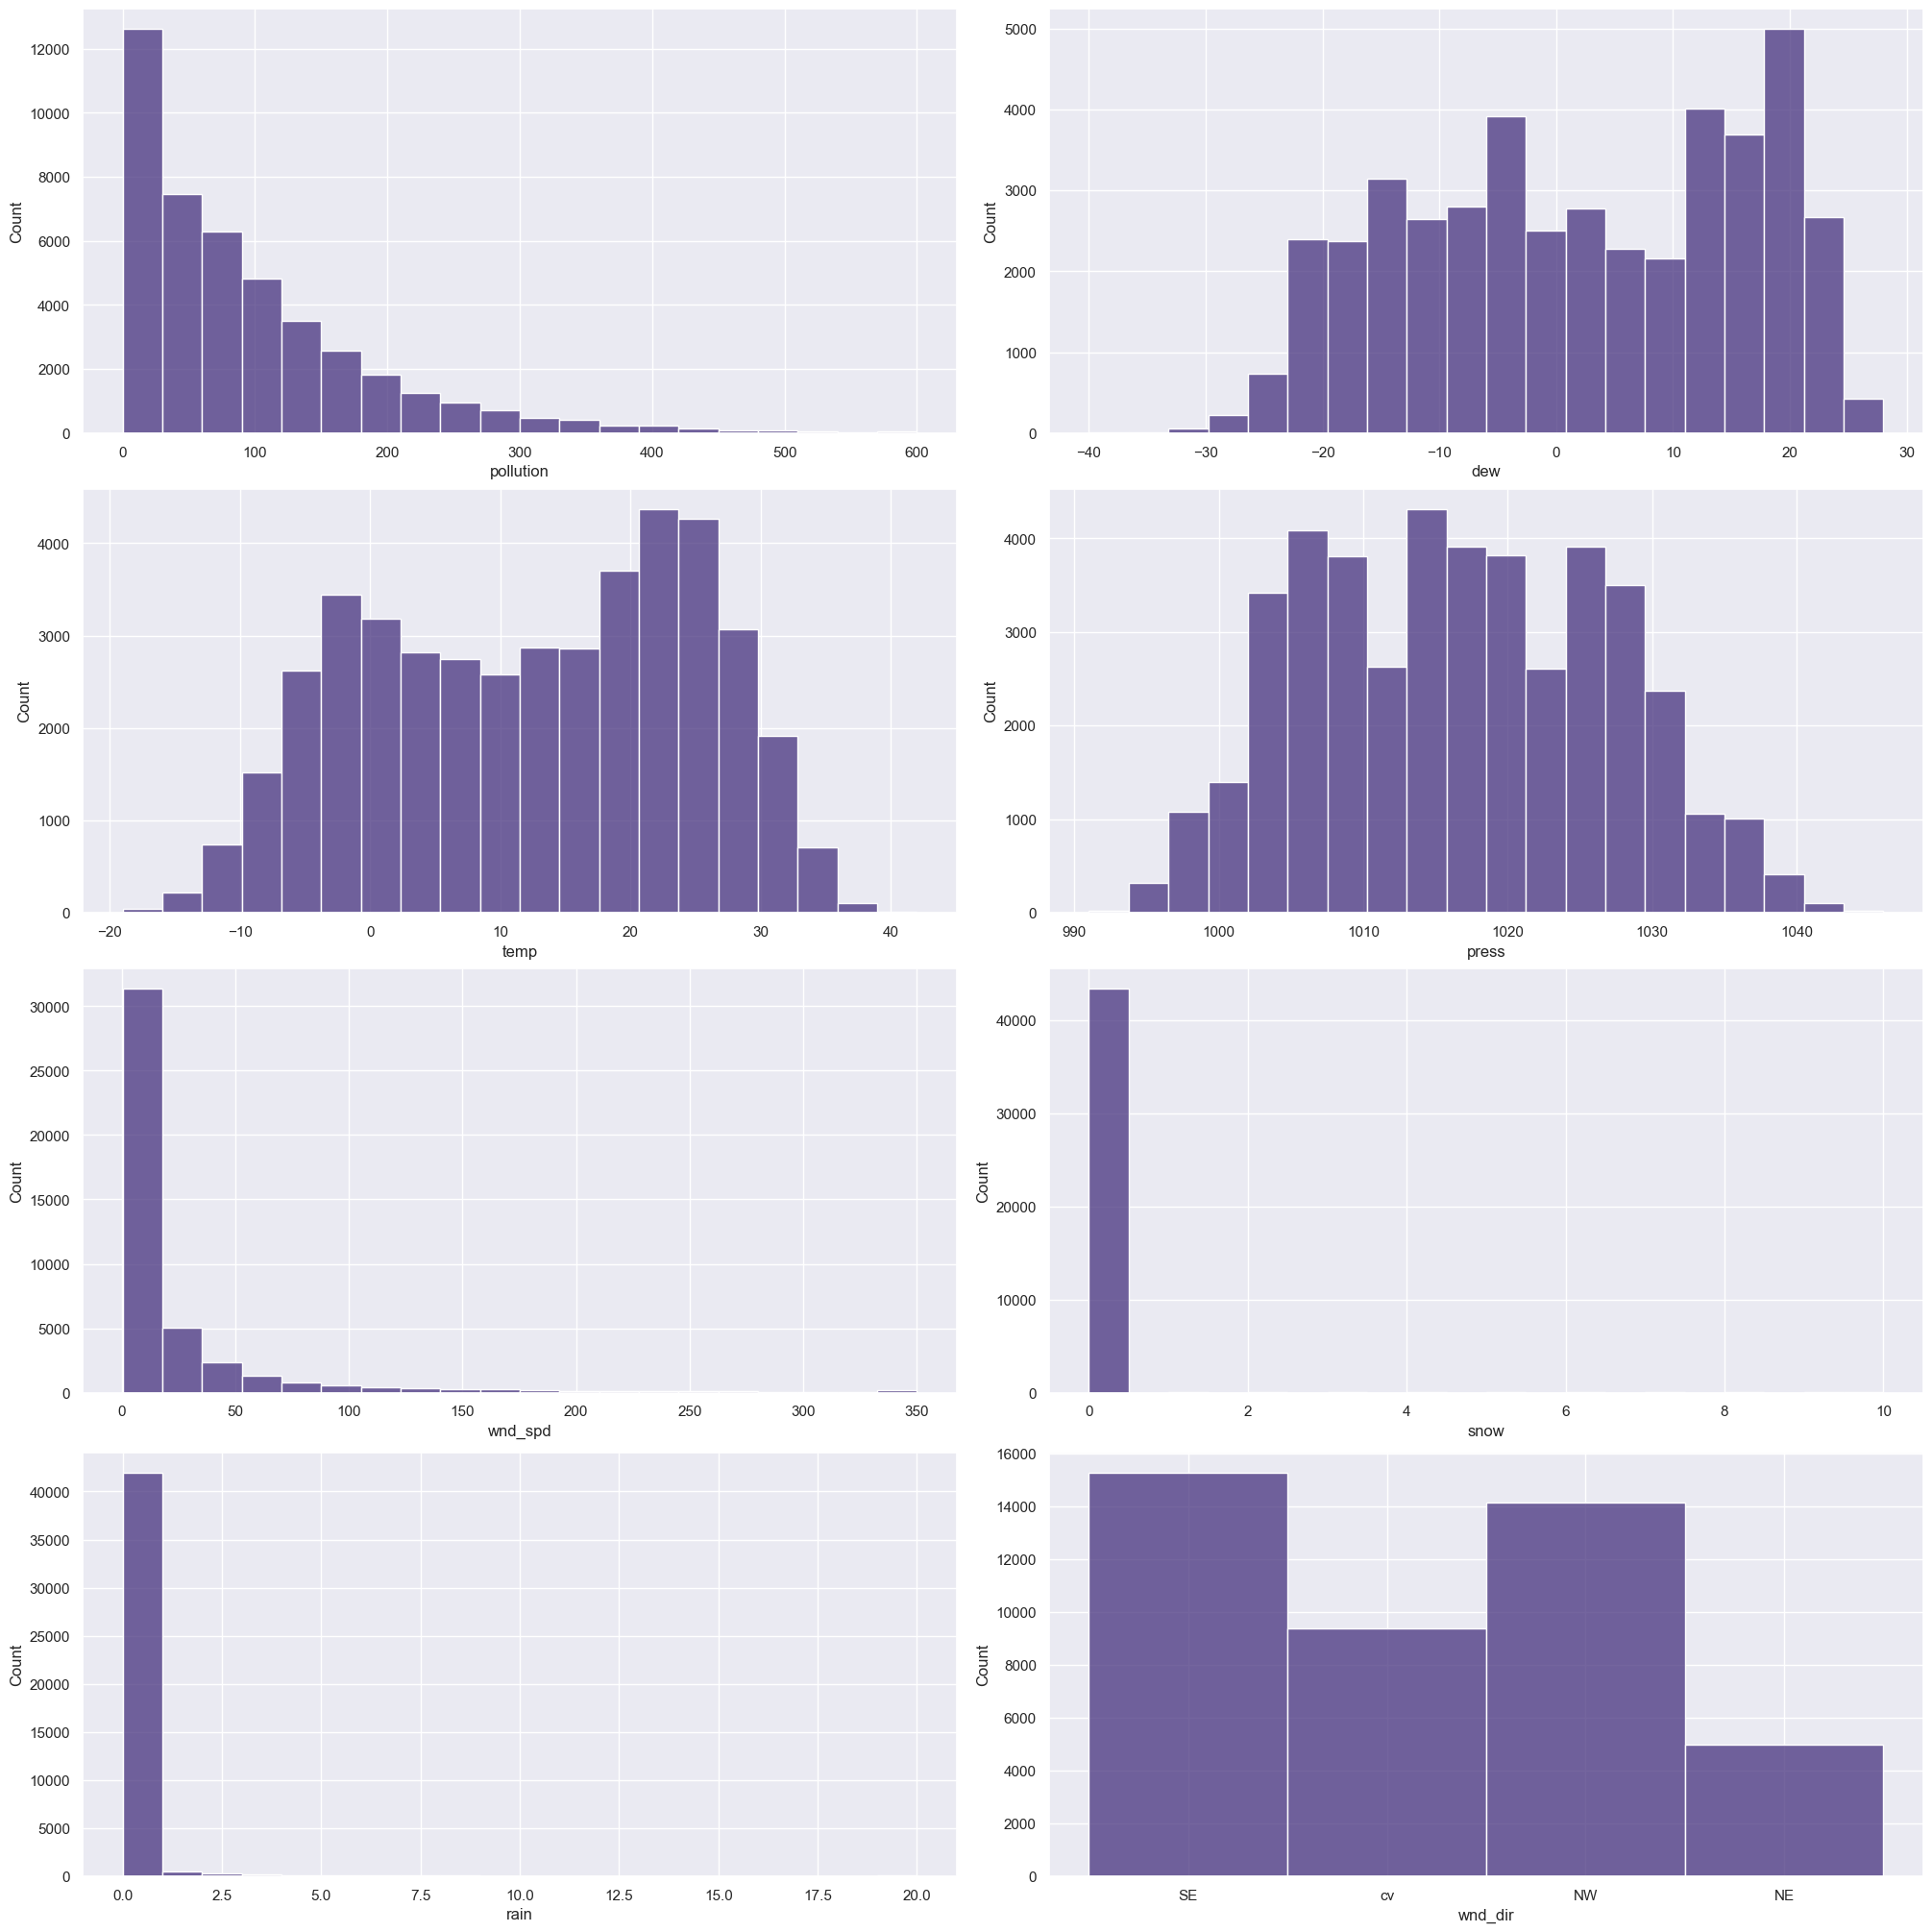

In [13]:
numerical = ['pollution',	'dew',	'temp',	'press', 'wnd_spd', 'snow', 'rain']
fig, axs = plt.subplots(4, 2,
                        figsize=(20, 20), constrained_layout=True)

for i, f in enumerate(numerical):
    sns.histplot(x=f, data=df,
                 ax=axs[i//2][i % 2], bins=20,
                 palette=sns.color_palette("viridis", 2))
sns.histplot(x='wnd_dir', data=df)

plt.show()

In [14]:
df = pd.get_dummies(
    data=df, columns=['wnd_dir'])
df.head()

,date,pollution,dew,temp,press,wnd_spd,snow,rain,wnd_dir_NE,wnd_dir_NW,wnd_dir_SE,wnd_dir_cv
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,False,False,True,False
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,False,False,True,False
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,False,False,True,False
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,False,False,True,False
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,False,False,True,False


In [15]:
df_test = pd.read_csv("pollution_test_data1.csv")
df_test['snow'] = df_test['snow'].apply(lambda x: 10 if x > 10 else x)
df_test['rain'] = df_test['rain'].apply(lambda x: 20 if x > 20 else x)
df_test['pollution'] = df_test['pollution'].apply(
    lambda x: 600 if x > 600 else x)
df_test['wnd_spd'] = df_test['wnd_spd'].apply(lambda x: 350 if x > 350 else x)
# df_test['wnd_spd'] = np.log(df_test['wnd_spd'])
df_test = pd.get_dummies(
    data=df_test, columns=['wnd_dir'])
df_test.head()

,dew,temp,press,wnd_spd,snow,rain,pollution,wnd_dir_NE,wnd_dir_NW,wnd_dir_SE,wnd_dir_cv
0,-16,4,1027,3.58,0,0,128,False,False,True,False
1,-17,5,1027,7.60,0,0,77,False,False,True,False
2,-16,4,1027,9.39,0,0,65,False,False,True,False
3,-16,1,1028,0.89,0,0,79,False,False,False,True
4,-14,0,1028,1.79,0,0,93,True,False,False,False


In [16]:
scaler = MinMaxScaler()
columns = (['pollution', 'dew', 'temp', 'press', "wnd_dir_NE", "wnd_dir_NW",	"wnd_dir_SE",	"wnd_dir_cv", 'wnd_spd',
            'snow', 'rain'])

df_train_scaled = df.copy()
df_test_scaled = df_test.copy()

df_train_scaled[columns] = scaler.fit_transform(df_train_scaled[columns])
df_test_scaled[columns] = scaler.transform(df_test_scaled[columns])

df_train_scaled.drop(columns=["date"], inplace=True)

df_train_scaled.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain,wnd_dir_NE,wnd_dir_NW,wnd_dir_SE,wnd_dir_cv
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,0.156514,0.615125,0.515722,0.462678,0.066416,0.004384,0.009460,0.114064,0.322603,0.349087,0.214247
std,0.152566,0.212196,0.199892,0.186753,0.138018,0.056726,0.065641,0.317893,0.467477,0.476687,0.410303
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.040000,0.441176,0.344262,0.309091,0.003834,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.113333,0.617647,0.540984,0.454545,0.014075,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.220417,0.808824,0.688525,0.618182,0.061393,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
df_test_scaled.describe()

,dew,temp,press,wnd_spd,snow,rain,pollution,wnd_dir_NE,wnd_dir_NW,wnd_dir_SE,wnd_dir_cv
count,346.000000,346.000000,346.000000,346.000000,346.0,346.0,346.000000,346.000000,346.000000,346.000000,346.000000
mean,0.384138,0.300768,0.637888,0.171873,0.0,0.0,0.160665,0.098266,0.595376,0.098266,0.208092
std,0.059264,0.074569,0.109023,0.290443,0.0,0.0,0.163831,0.298105,0.491530,0.298105,0.406531
min,0.191176,0.163934,0.363636,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.352941,0.245902,0.563636,0.006351,0.0,0.0,0.023333,0.000000,0.000000,0.000000,0.000000
50%,0.382353,0.286885,0.654545,0.021099,0.0,0.0,0.105833,0.000000,1.000000,0.000000,0.000000
75%,0.426471,0.344262,0.727273,0.166879,0.0,0.0,0.262500,0.000000,1.000000,0.000000,0.000000
max,0.500000,0.491803,0.800000,1.000000,0.0,0.0,0.740000,1.000000,1.000000,1.000000,1.000000


In [18]:
print(df_train_scaled.columns)
print(df_test_scaled.columns)

Index(['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain',
       'wnd_dir_NE', 'wnd_dir_NW', 'wnd_dir_SE', 'wnd_dir_cv'],
      dtype='object')
Index(['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'pollution',
       'wnd_dir_NE', 'wnd_dir_NW', 'wnd_dir_SE', 'wnd_dir_cv'],
      dtype='object')


In [19]:
df_test_scaled = df_test_scaled.reindex(columns=df_train_scaled.columns)


print(df_train_scaled.columns)


print(df_test_scaled.columns)

Index(['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain',
       'wnd_dir_NE', 'wnd_dir_NW', 'wnd_dir_SE', 'wnd_dir_cv'],
      dtype='object')
Index(['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain',
       'wnd_dir_NE', 'wnd_dir_NW', 'wnd_dir_SE', 'wnd_dir_cv'],
      dtype='object')


In [20]:
df_train_scaled.shape

(43800, 11)

In [21]:
def split_into_windows(data: pd.DataFrame, target: str, window_size=11, step_size=1):
    X, y = [], []
    data_values = data.drop(columns=[target])
    for i in range(0, len(data) - window_size, step_size):
        X.append(data_values.iloc[i:i+window_size].values)
        y.append(data.iloc[i+window_size][target])
    return np.array(X), np.array(y)

In [22]:
X_train, y_train = split_into_windows(df_train_scaled, 'pollution')
X_test, y_test = split_into_windows(df_test_scaled, 'pollution')
print("Train size : ", X_train.shape, y_train.shape, "\n ------- \n"
      "Test Size : ", X_test.shape, y_test.shape)

Train size :  (43789, 11, 10) (43789,) 
 ------- 
Test Size :  (335, 11, 10) (335,)


## Isprobavanje modela


In [23]:
import sklearn.metrics as metrics

In [24]:
def plot_train_history(history):
    plt.figure(figsize=(15, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [30]:
all_results = pd.DataFrame(columns=['Model', 'RMSE', 'MAE', 'R2', 'MSE'])

In [31]:

def test_model(model, model_name, X_test, y_test, end=-1):
    X_test = X_test[:end]
    y_test = y_test[:end]
    y_pred = model.predict(X_test).flatten()
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    mae = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    all_results.loc[len(all_results)] = [model_name, rmse, mae, r2, mse]

    plt.figure(figsize=(15, 6))
    plt.plot(y_test, label='True')
    plt.plot(y_pred, label='Predicted')
    plt.title(f'{model_name} Predictions')
    plt.legend()
    plt.show()

    display(all_results[-1:])

In [27]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras', monitor='val_loss', save_best_only=True)

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=(
        X_train.shape[1], X_train.shape[2]), return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(16, return_sequences=False),
    tf.keras.layers.Dense(1)
])
model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.metrics.RootMeanSquaredError()]
)
model.summary()
history = model.fit(X_train, y_train,
                    epochs=20, batch_size=32,
                    validation_split=0.1,
                    callbacks=[early_stopping, checkpoint])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 11, 32)            5504      
                                                                 
 dropout (Dropout)           (None, 11, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 8657 (33.82 KB)
Trainable params: 8657 (33.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20

1232/1232 [==============================] - 11s 6ms/step - loss: 0.0166 - root_mean_squared_error: 0.1289 - val_loss: 0.0140 - val_root_mean

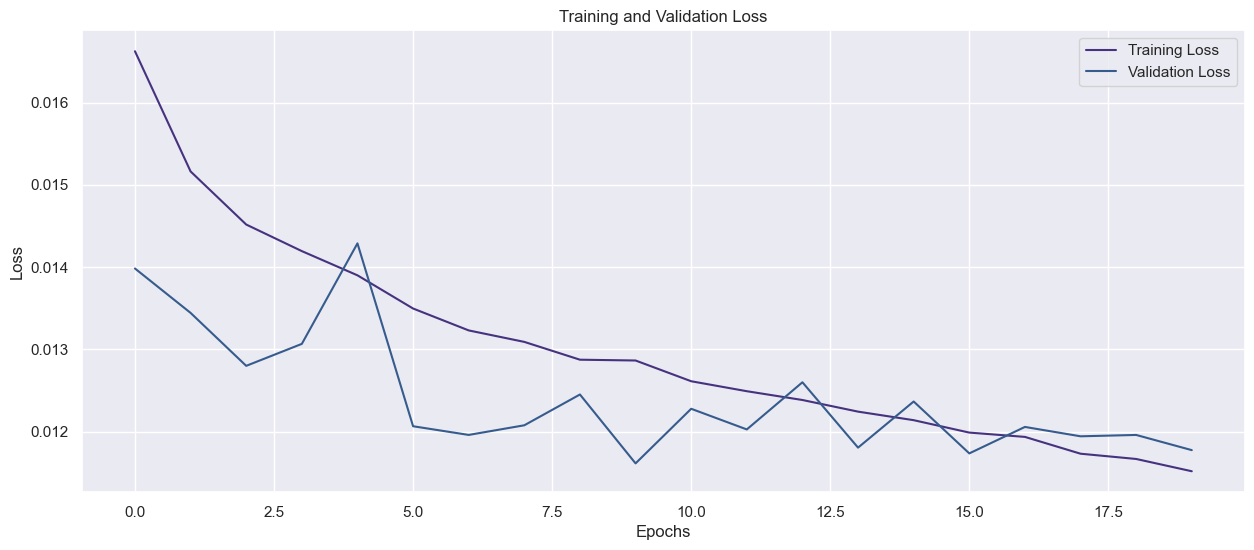

7/7 [==============================] - 1s 2ms/step


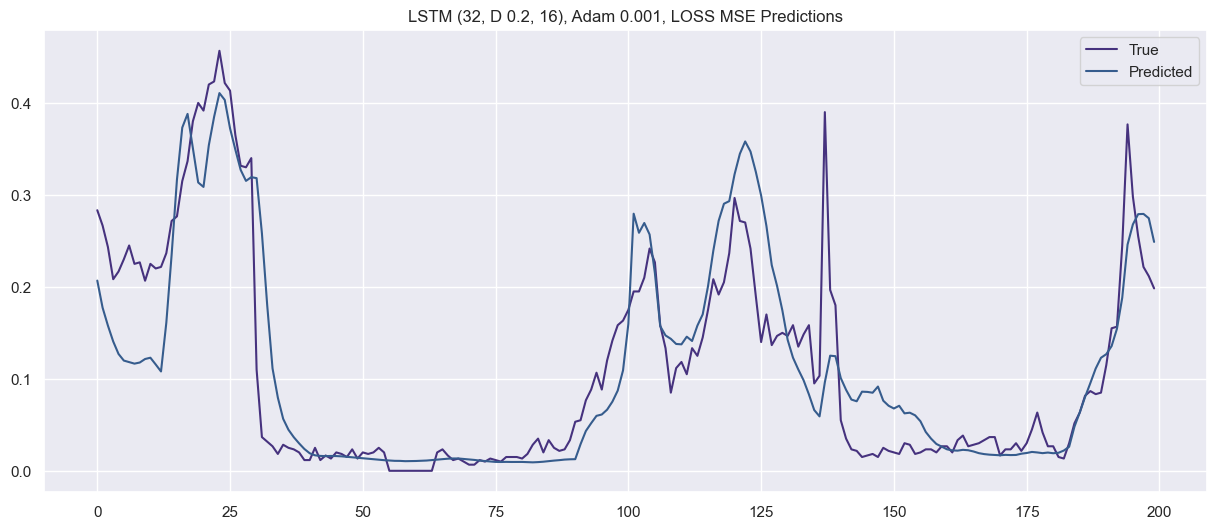

,Model,RMSE,MAE,R2,MSE
2,"LSTM (32, D 0.2, 16), Adam 0.001, LOSS MSE",0.056871,0.037992,0.758851,0.003234


In [34]:
plot_train_history(history)
best_model = tf.keras.models.load_model('best_model.keras')
test_model(best_model, 'LSTM (32, D 0.2, 16), Adam 0.001, LOSS MSE',
           X_test, y_test, 200)

In [37]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=(
        X_train.shape[1], X_train.shape[2]), return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(16, return_sequences=False),
    tf.keras.layers.Dense(1)
])
model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(learning_rate=0.0002),
    metrics=[tf.metrics.RootMeanSquaredError()]
)
model.summary()
history = model.fit(X_train, y_train,
                    epochs=40, batch_size=32,
                    validation_split=0.1,
                    callbacks=[early_stopping, checkpoint])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 11, 32)            5504      
                                                                 
 dropout_2 (Dropout)         (None, 11, 32)            0         
                                                                 
 lstm_5 (LSTM)               (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8657 (33.82 KB)
Trainable params: 8657 (33.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
1232/1232 [==============================] - 11s 6ms/step - loss: 0.0194 - root_mean_squared_error: 0.1391 - val_loss: 0.0156 - val_root_mean

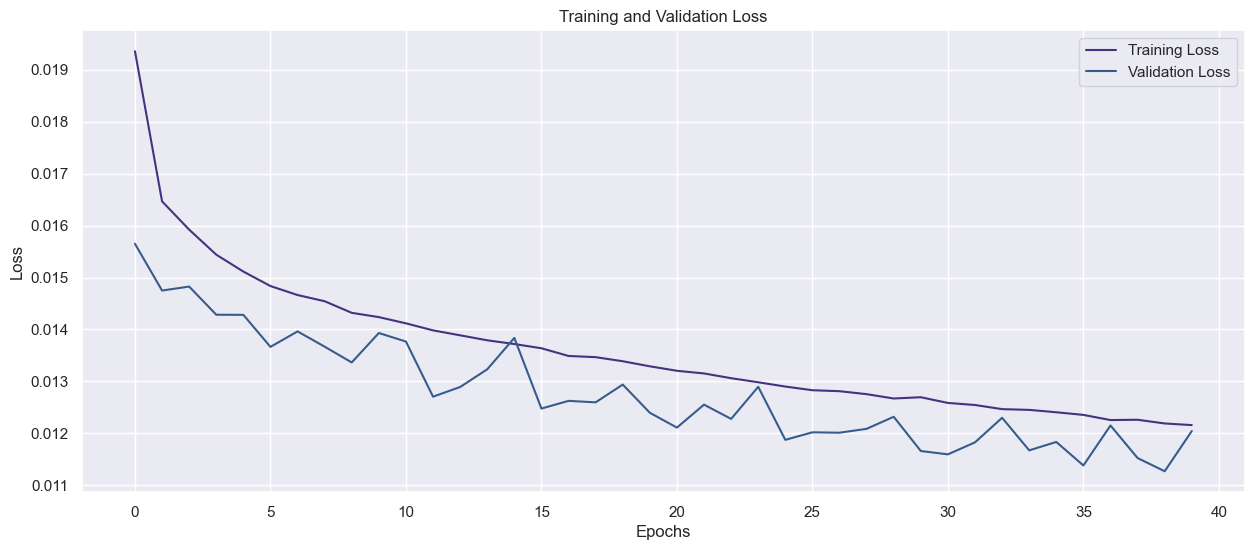

7/7 [==============================] - 0s 2ms/step


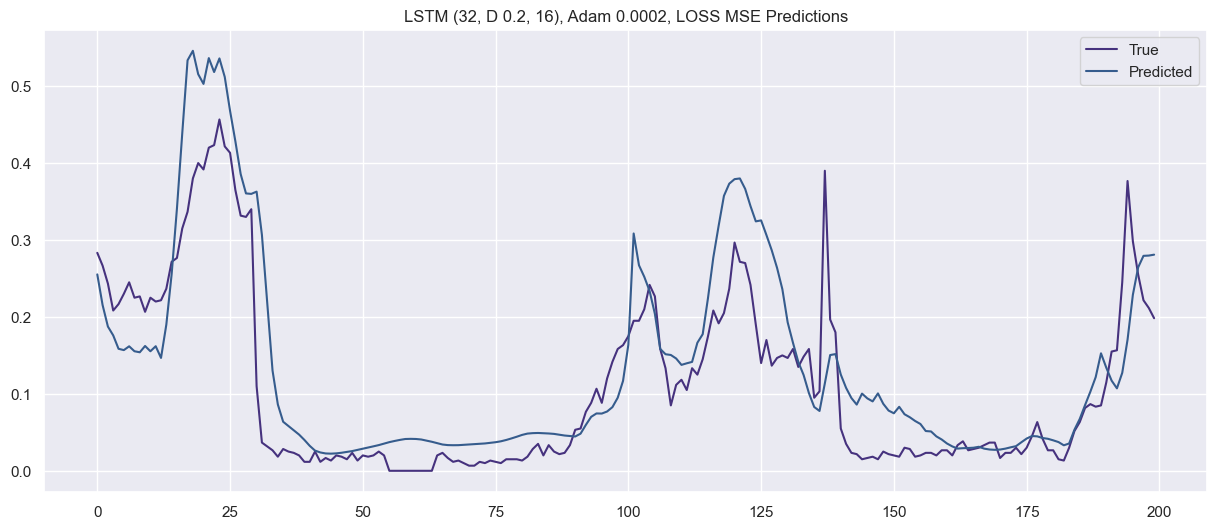

,Model,RMSE,MAE,R2,MSE
5,"LSTM (32, D 0.2, 16), Adam 0.0002, LOSS MSE",0.068592,0.04802,0.649207,0.004705


In [39]:
plot_train_history(history)
# best_model = tf.keras.models.load_model('best_model.keras')
test_model(model, 'LSTM (32, D 0.2, 16), Adam 0.0002, LOSS MSE',
           X_test, y_test, 200)

In [40]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=(
        X_train.shape[1], X_train.shape[2]), return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32, input_shape=(
        X_train.shape[1], X_train.shape[2]), return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(16, return_sequences=False),
    tf.keras.layers.Dense(1)
])
model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.metrics.RootMeanSquaredError()]
)
model.summary()
history = model.fit(X_train, y_train,
                    epochs=20, batch_size=32,
                    validation_split=0.1,
                    callbacks=[early_stopping, checkpoint])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 11, 32)            5504      
                                                                 
 dropout_3 (Dropout)         (None, 11, 32)            0         
                                                                 
 lstm_7 (LSTM)               (None, 11, 32)            8320      
                                                                 
 dropout_4 (Dropout)         (None, 11, 32)            0         
                                                                 
 lstm_8 (LSTM)               (None, 16)                3136      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 16977 (66.32 KB)
Trainable params: 16977

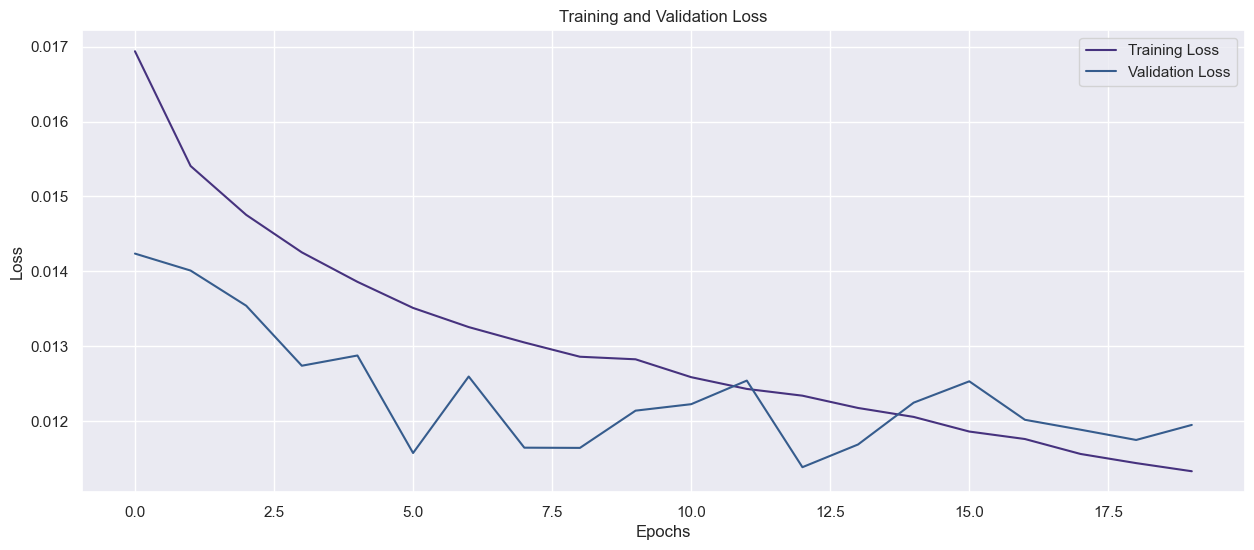

7/7 [==============================] - 0s 2ms/step


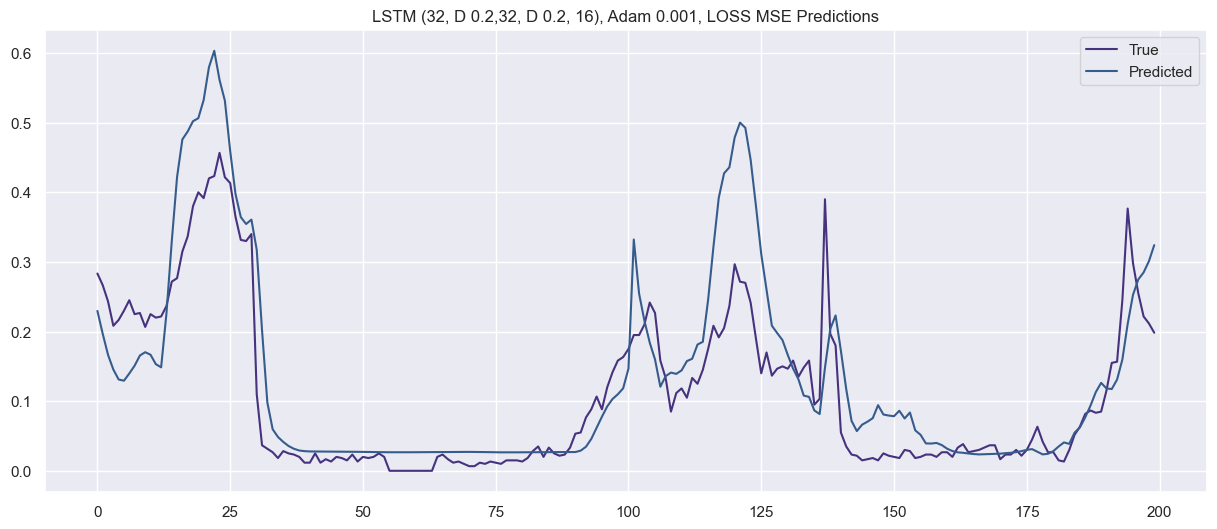

,Model,RMSE,MAE,R2,MSE
7,"LSTM (32, D 0.2,32, D 0.2, 16), Adam 0.001, LO...",0.071857,0.047345,0.615013,0.005163


In [42]:
plot_train_history(history)
best_model = tf.keras.models.load_model('best_model.keras')
test_model(model, 'LSTM (32, D 0.2,32, D 0.2, 16), Adam 0.001, LOSS MSE',
           X_test, y_test, 200)

In [43]:
model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, input_shape=(
        X_train.shape[1], X_train.shape[2]), return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(16, return_sequences=False),
    tf.keras.layers.Dense(1)
])
model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.metrics.RootMeanSquaredError()]
)
model.summary()
history = model.fit(X_train, y_train,
                    epochs=20, batch_size=32,
                    validation_split=0.1,
                    callbacks=[early_stopping, checkpoint])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 11, 32)            4224      
                                                                 
 dropout_5 (Dropout)         (None, 11, 32)            0         
                                                                 
 gru_1 (GRU)                 (None, 16)                2400      
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 6641 (25.94 KB)
Trainable params: 6641 (25.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
1232/1232 [==============================] - 12s 6ms/step - loss: 0.0175 - root_mean_squared_error: 0.1323 - val_loss: 0.0142 - val_root_mean

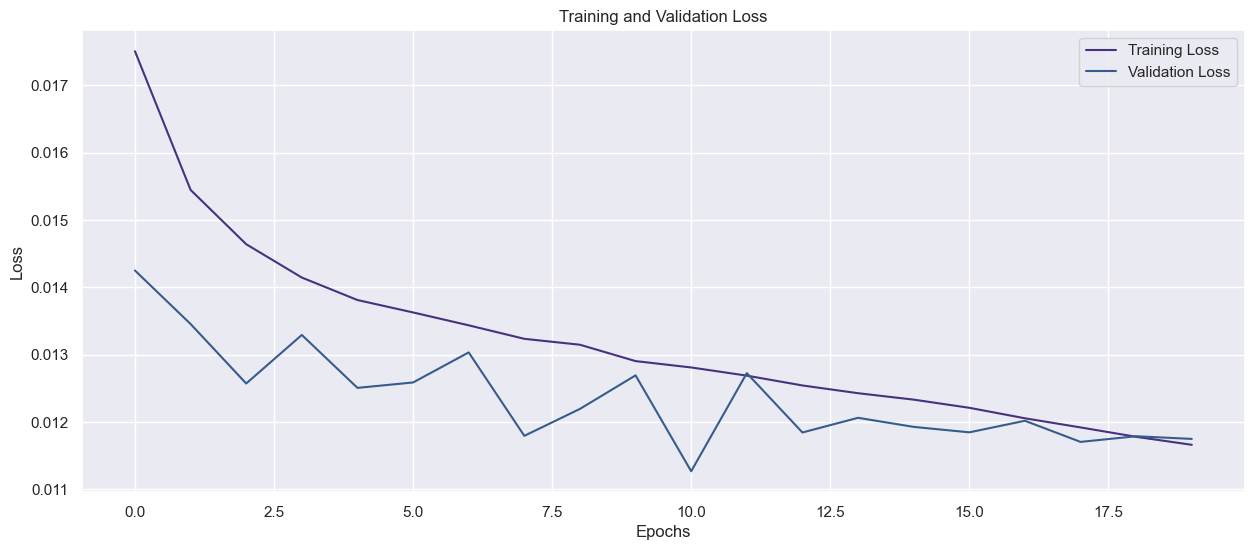

7/7 [==============================] - 1s 2ms/step


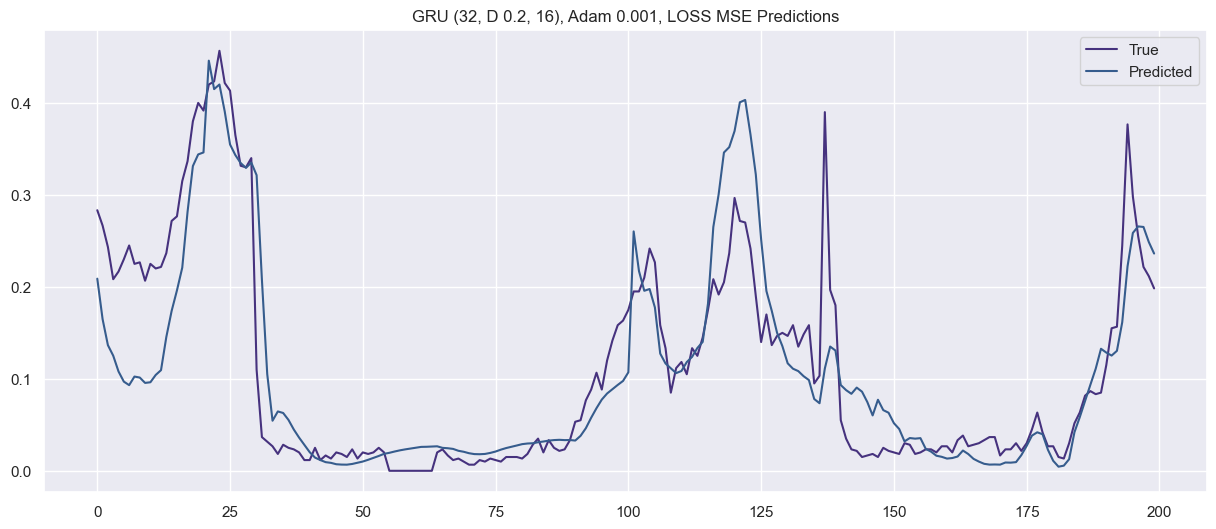

,Model,RMSE,MAE,R2,MSE
9,"GRU (32, D 0.2, 16), Adam 0.001, LOSS MSE",0.057503,0.038096,0.753458,0.003307


In [45]:
plot_train_history(history)
best_model = tf.keras.models.load_model('best_model.keras')
test_model(best_model, 'GRU (32, D 0.2, 16), Adam 0.001, LOSS MSE',
           X_test, y_test, 200)

In [49]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu',
                           input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32, input_shape=(
        X_train.shape[1], X_train.shape[2]), return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(16, return_sequences=False),
    tf.keras.layers.Dense(1)
])
model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(learning_rate=0.0007),
    metrics=[tf.metrics.RootMeanSquaredError()]
)
model.summary()
history = model.fit(X_train, y_train,
                    epochs=40, batch_size=32,
                    validation_split=0.1,
                    callbacks=[early_stopping, checkpoint])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 9, 64)             1984      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 4, 64)             0         
 g1D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 4, 64)             0         
                                                                 
 lstm_11 (LSTM)              (None, 4, 32)             12416     
                                                                 
 dropout_9 (Dropout)         (None, 4, 32)             0         
                                                                 
 lstm_12 (LSTM)              (None, 16)                3136      
                                                      

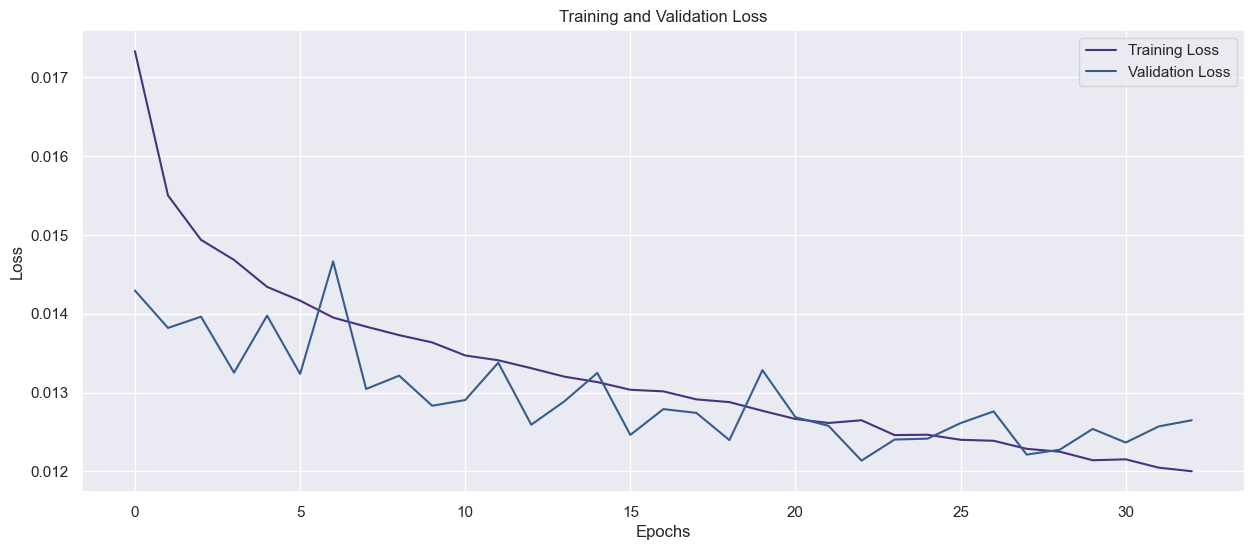

7/7 [==============================] - 1s 2ms/step


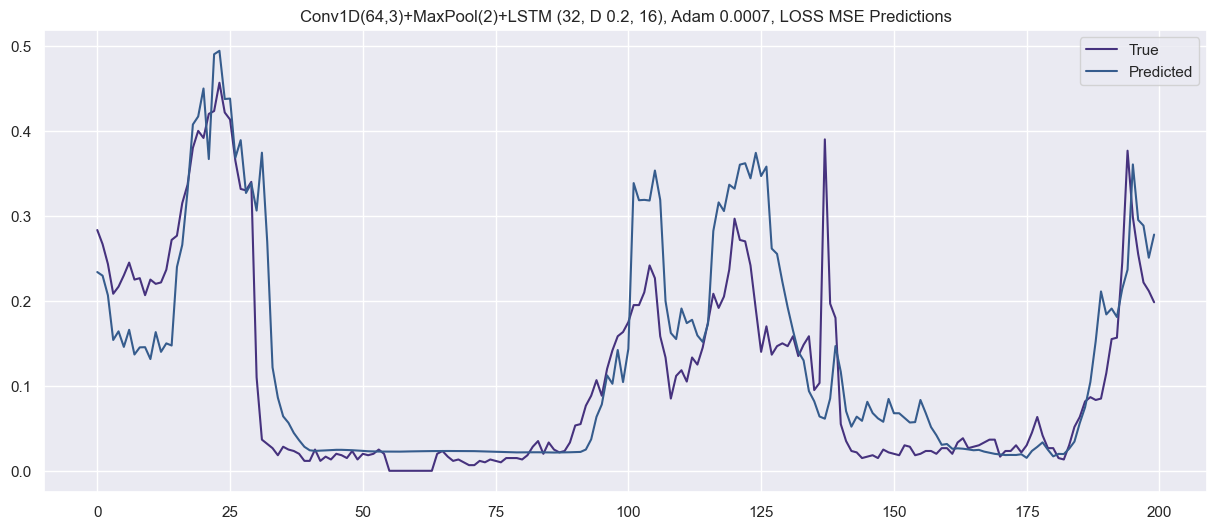

,Model,RMSE,MAE,R2,MSE
11,"Conv1D(64,3)+MaxPool(2)+LSTM (32, D 0.2, 16), ...",0.068093,0.043843,0.654287,0.004637


In [50]:
plot_train_history(history)
# best_model = tf.keras.models.load_model('best_model.keras')
test_model(model, 'Conv1D(64,3)+MaxPool(2)+LSTM (32, D 0.2, 16), Adam 0.0007, LOSS MSE',
           X_test, y_test, 200)

In [53]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=(
        X_train.shape[1], X_train.shape[2]), return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(16, return_sequences=False),
    tf.keras.layers.Dense(1)
])
model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adamax(learning_rate=0.001),
    metrics=[tf.metrics.RootMeanSquaredError()]
)
model.summary()
history = model.fit(X_train, y_train,
                    epochs=40, batch_size=32,
                    validation_split=0.1,
                    callbacks=[early_stopping, checkpoint])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 11, 32)            5504      
                                                                 
 dropout_11 (Dropout)        (None, 11, 32)            0         
                                                                 
 lstm_16 (LSTM)              (None, 16)                3136      
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8657 (33.82 KB)
Trainable params: 8657 (33.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
1232/1232 [==============================] - 12s 6ms/step - loss: 0.0174 - root_mean_squared_error: 0.1319 - val_loss: 0.0145 - val_root_mean

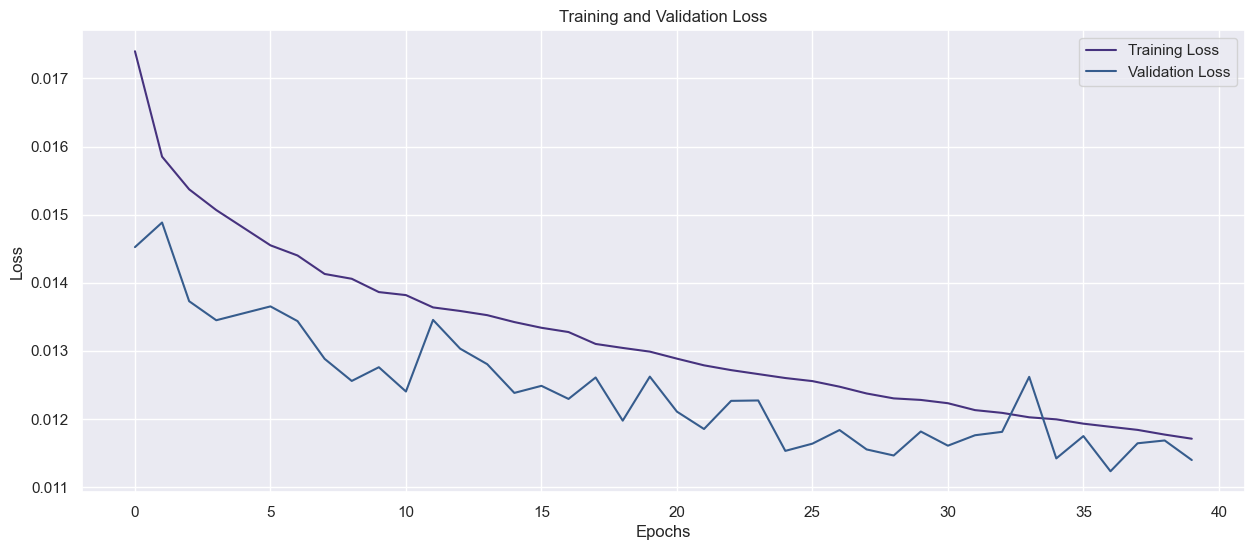

7/7 [==============================] - 1s 2ms/step


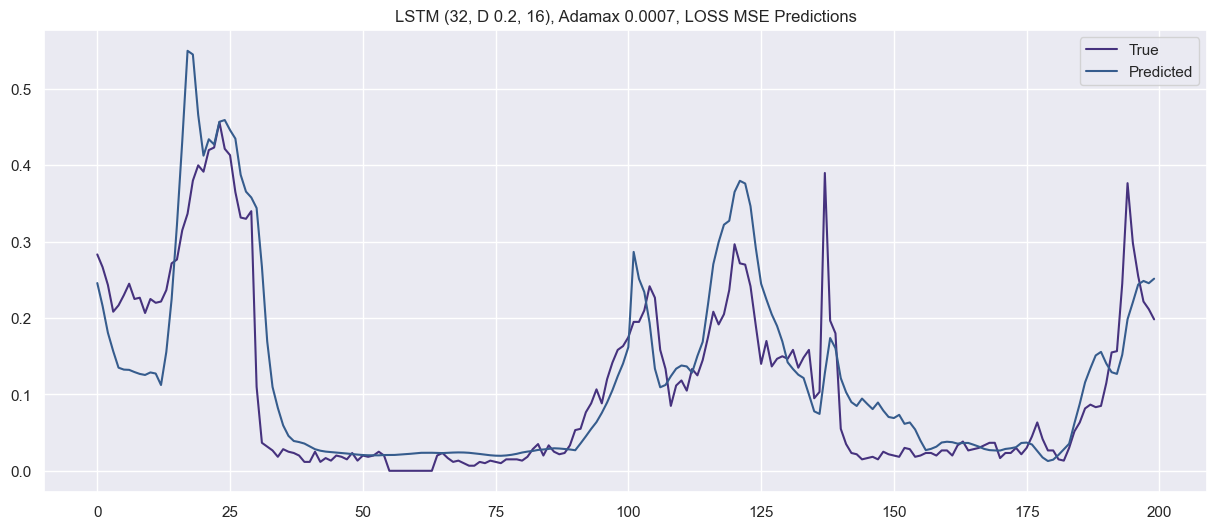

,Model,RMSE,MAE,R2,MSE
14,"LSTM (32, D 0.2, 16), Adamax 0.0007, LOSS MSE",0.059422,0.039719,0.736731,0.003531


In [55]:
plot_train_history(history)
best_model = tf.keras.models.load_model('best_model.keras')
test_model(best_model, 'LSTM (32, D 0.2, 16), Adamax 0.0007, LOSS MSE',
           X_test, y_test, 200)

In [65]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=(
        X_train.shape[1], X_train.shape[2]), return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(16, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.metrics.RootMeanSquaredError()]
)
model.summary()
history = model.fit(X_train, y_train,
                    epochs=14, batch_size=32,
                    validation_split=0.1,
                    callbacks=[early_stopping, checkpoint])

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 11, 32)            5504      
                                                                 
 dropout_22 (Dropout)        (None, 11, 32)            0         
                                                                 
 lstm_28 (LSTM)              (None, 16)                3136      
                                                                 
 dropout_23 (Dropout)        (None, 16)                0         
                                                                 
 dense_22 (Dense)            (None, 16)                272       
                                                                 
 dense_23 (Dense)            (None, 16)                272       
                                                                 
 dense_24 (Dense)            (None, 1)               

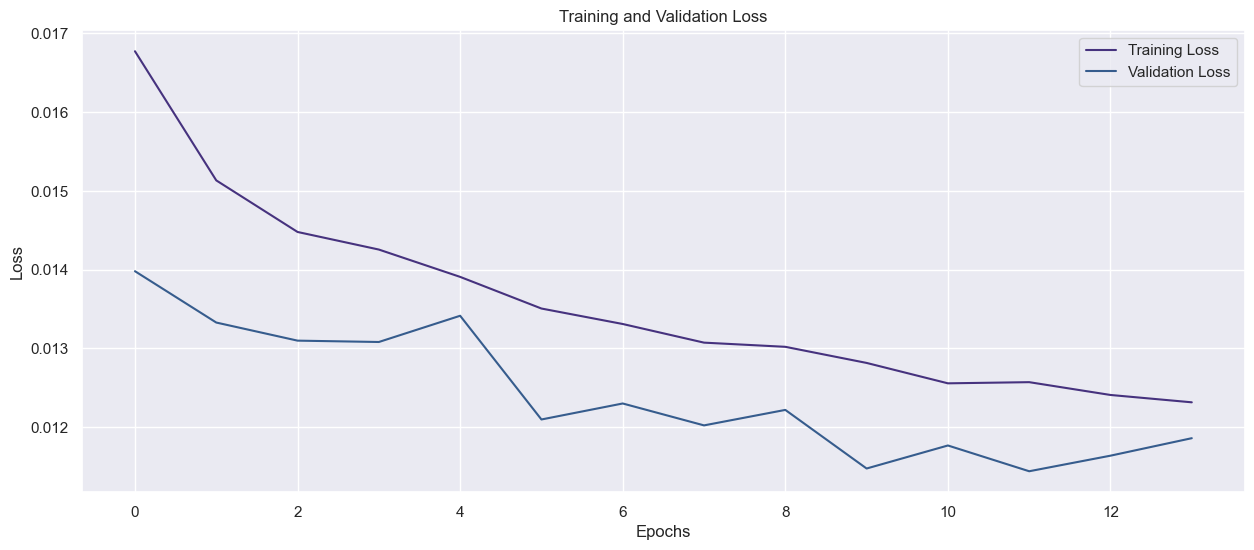

7/7 [==============================] - 1s 2ms/step


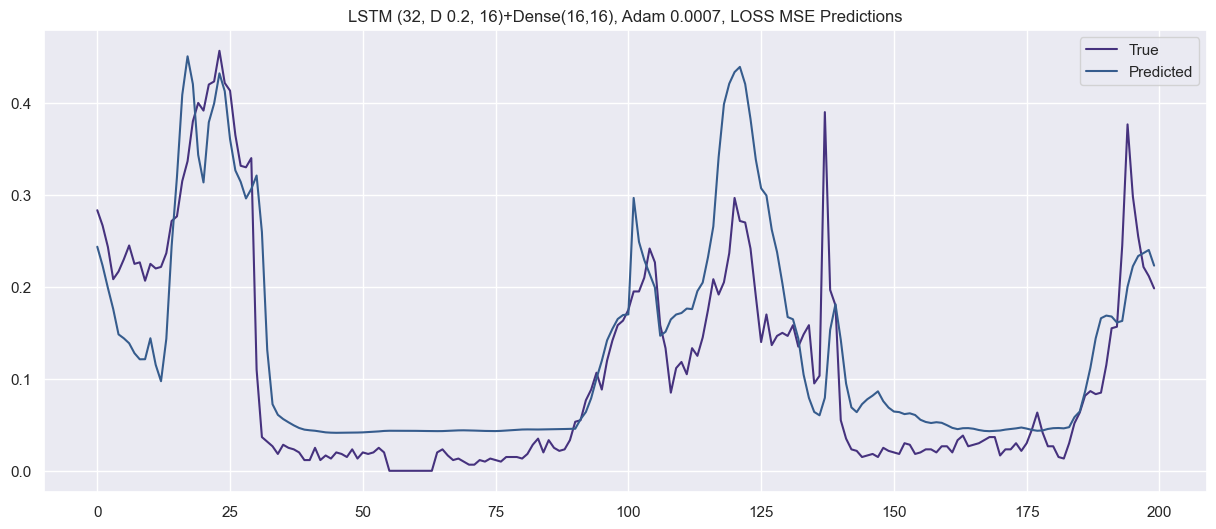

,Model,RMSE,MAE,R2,MSE
16,"LSTM (32, D 0.2, 16)+Dense(16,16), Adam 0.0007...",0.065518,0.047131,0.679945,0.004293


In [66]:
plot_train_history(history)
# best_model = tf.keras.models.load_model('best_model.keras')
test_model(model, 'LSTM (32, D 0.2, 16)+Dense(16,16), Adam 0.0007, LOSS MSE',
           X_test, y_test, 200)

In [67]:
all_results

,Model,RMSE,MAE,R2,MSE
0,LSTM,0.111226,0.068039,0.543626,0.012371
1,LSTM,0.056871,0.037992,0.758851,0.003234
2,"LSTM (32, D 0.2, 16), Adam 0.001, LOSS MSE",0.056871,0.037992,0.758851,0.003234
3,"LSTM (32, D 0.2, 16), Adam 0.001, LOSS MSE",0.059702,0.039785,0.734238,0.003564
4,"LSTM (32, D 0.2, 16), Adam 0.0005, LOSS MSE",0.068592,0.048020,0.649207,0.004705
5,"LSTM (32, D 0.2, 16), Adam 0.0002, LOSS MSE",0.068592,0.048020,0.649207,0.004705
6,"LSTM (32, D 0.2,32, D 0.2, 16), Adam 0.001, LO...",0.071857,0.047345,0.615013,0.005163
7,"LSTM (32, D 0.2,32, D 0.2, 16), Adam 0.001, LO...",0.071857,0.047345,0.615013,0.005163
8,"GRU (32, D 0.2, 16), Adam 0.001, LOSS MSE",0.069079,0.044129,0.644203,0.004772
9,"GRU (32, D 0.2, 16), Adam 0.001, LOSS MSE",0.057503,0.038096,0.753458,0.003307
